<center><img src="img/logo_hse.png" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ). 

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение. 
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="img/geo.jpg" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов. 

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [35]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("data/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [36]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [37]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [38]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [39]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [40]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

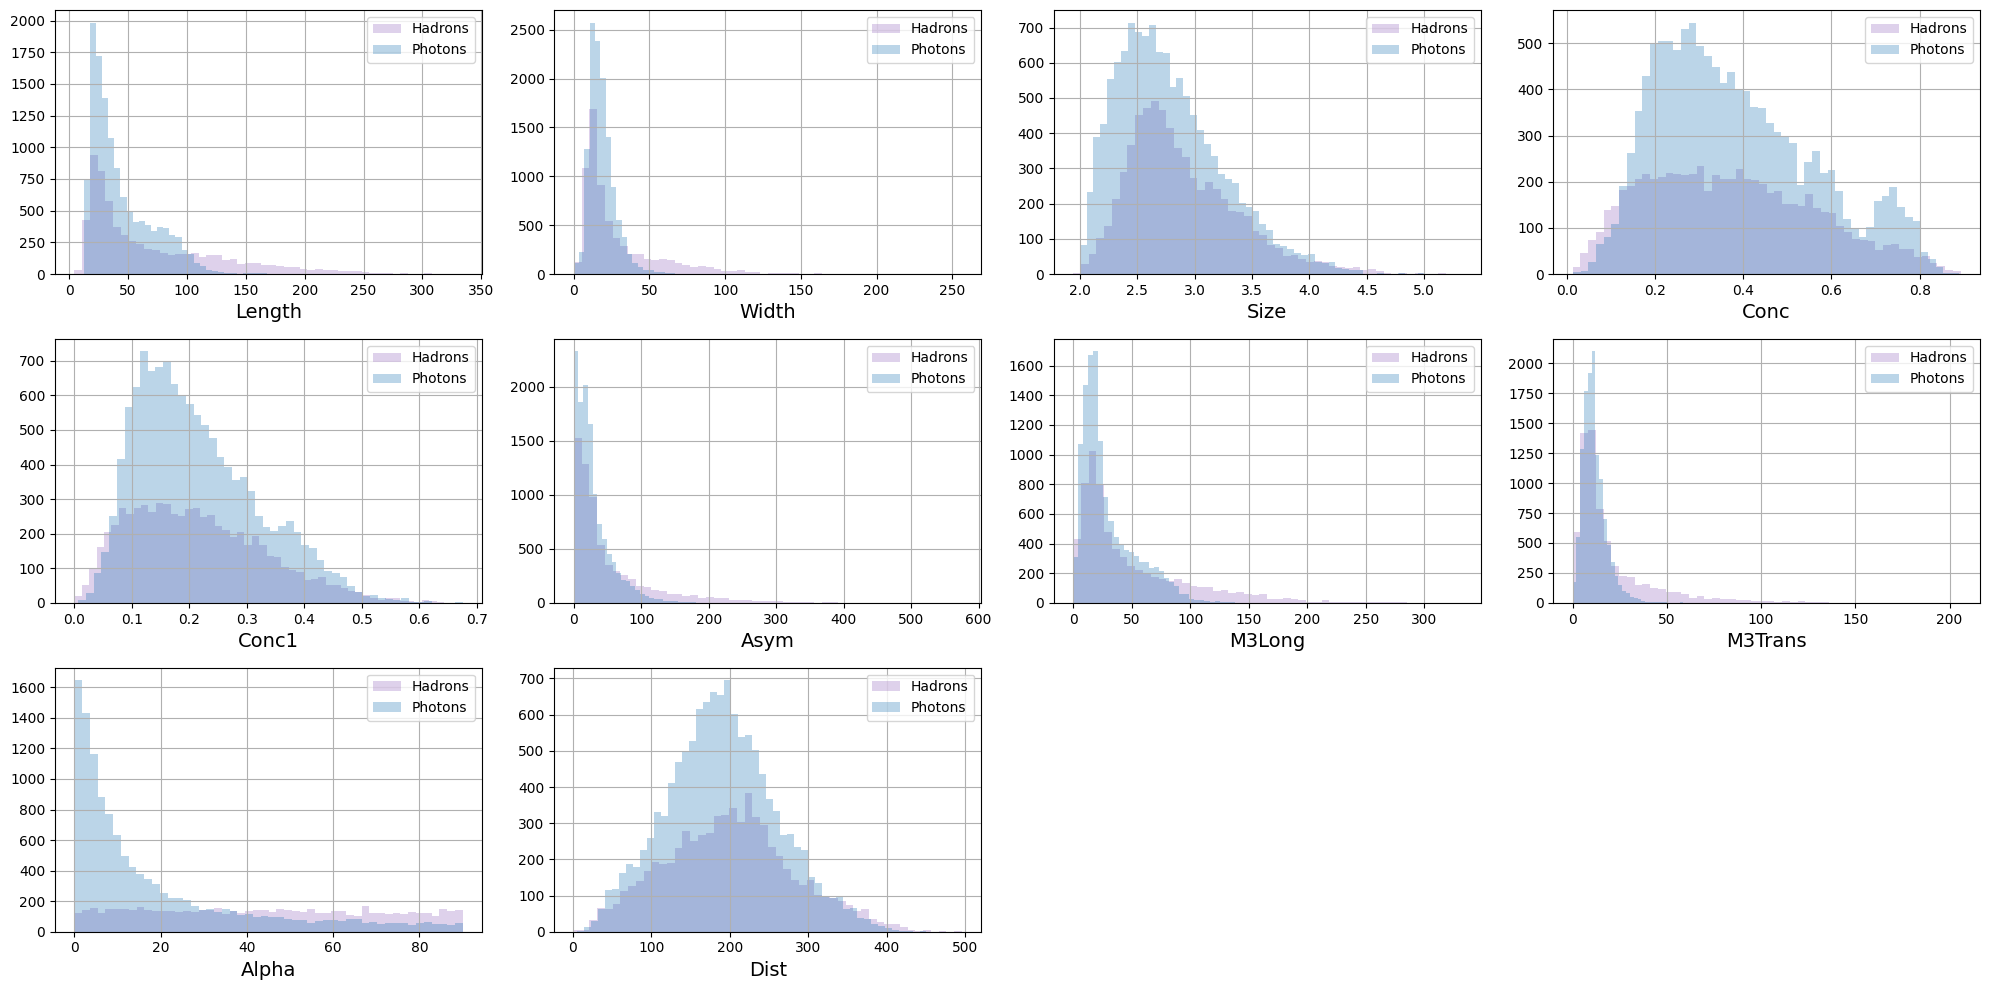

In [41]:
plot_hists(
    X[y[:, 0] == 0],
    X[y[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [42]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение y внутри train и test выборки.

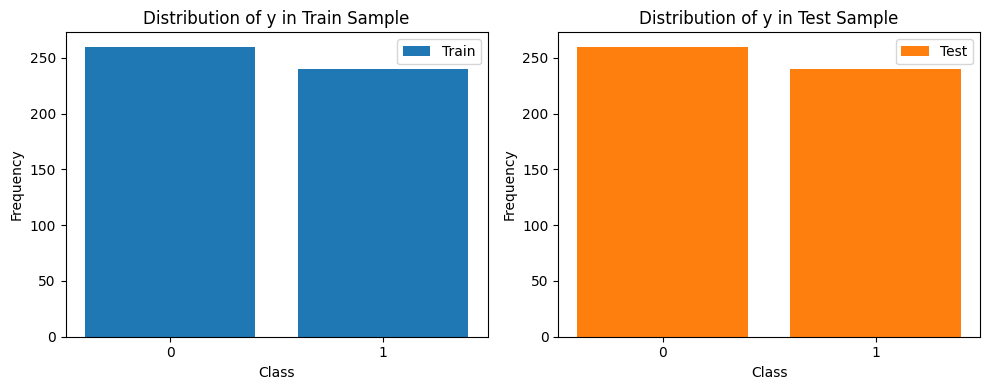

In [43]:
# Предполагаемые данные, так как исходные данные не предоставлены
# Симуляция данных для X и y
np.random.seed(11)
X = np.random.normal(size=(1000, 10))  # 1000 объектов, 10 признаков
y = np.random.choice([0, 1], size=(1000, 1))  # 1000 меток классов

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

# Построение графика распределения y в обучающей и тестовой выборках
plt.figure(figsize=(10, 4))

# Распределение в обучающей выборке
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=np.arange(-0.5, 2.5, 1), rwidth=0.8, color='C0', label='Train')
plt.xticks([0, 1])
plt.title('Distribution of y in Train Sample')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.legend()

# Распределение в тестовой выборке
plt.subplot(1, 2, 2)
plt.hist(y_test, bins=np.arange(-0.5, 2.5, 1), rwidth=0.8, color='C1', label='Test')
plt.xticks([0, 1])
plt.title('Distribution of y in Test Sample')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [44]:
from sklearn.preprocessing import QuantileTransformer

# Предполагаем, что размер вашего набора данных - 500 образцов
n_samples = min(500, X_train.shape[0])

# Инициализация QuantileTransformer с явным указанием n_quantiles
qt = QuantileTransformer(n_quantiles=n_samples, output_distribution='normal', random_state=0)

# Трансформация данных обучающего и тестового наборов
X_train_transformed = qt.fit_transform(X_train)
X_test_transformed = qt.transform(X_test)


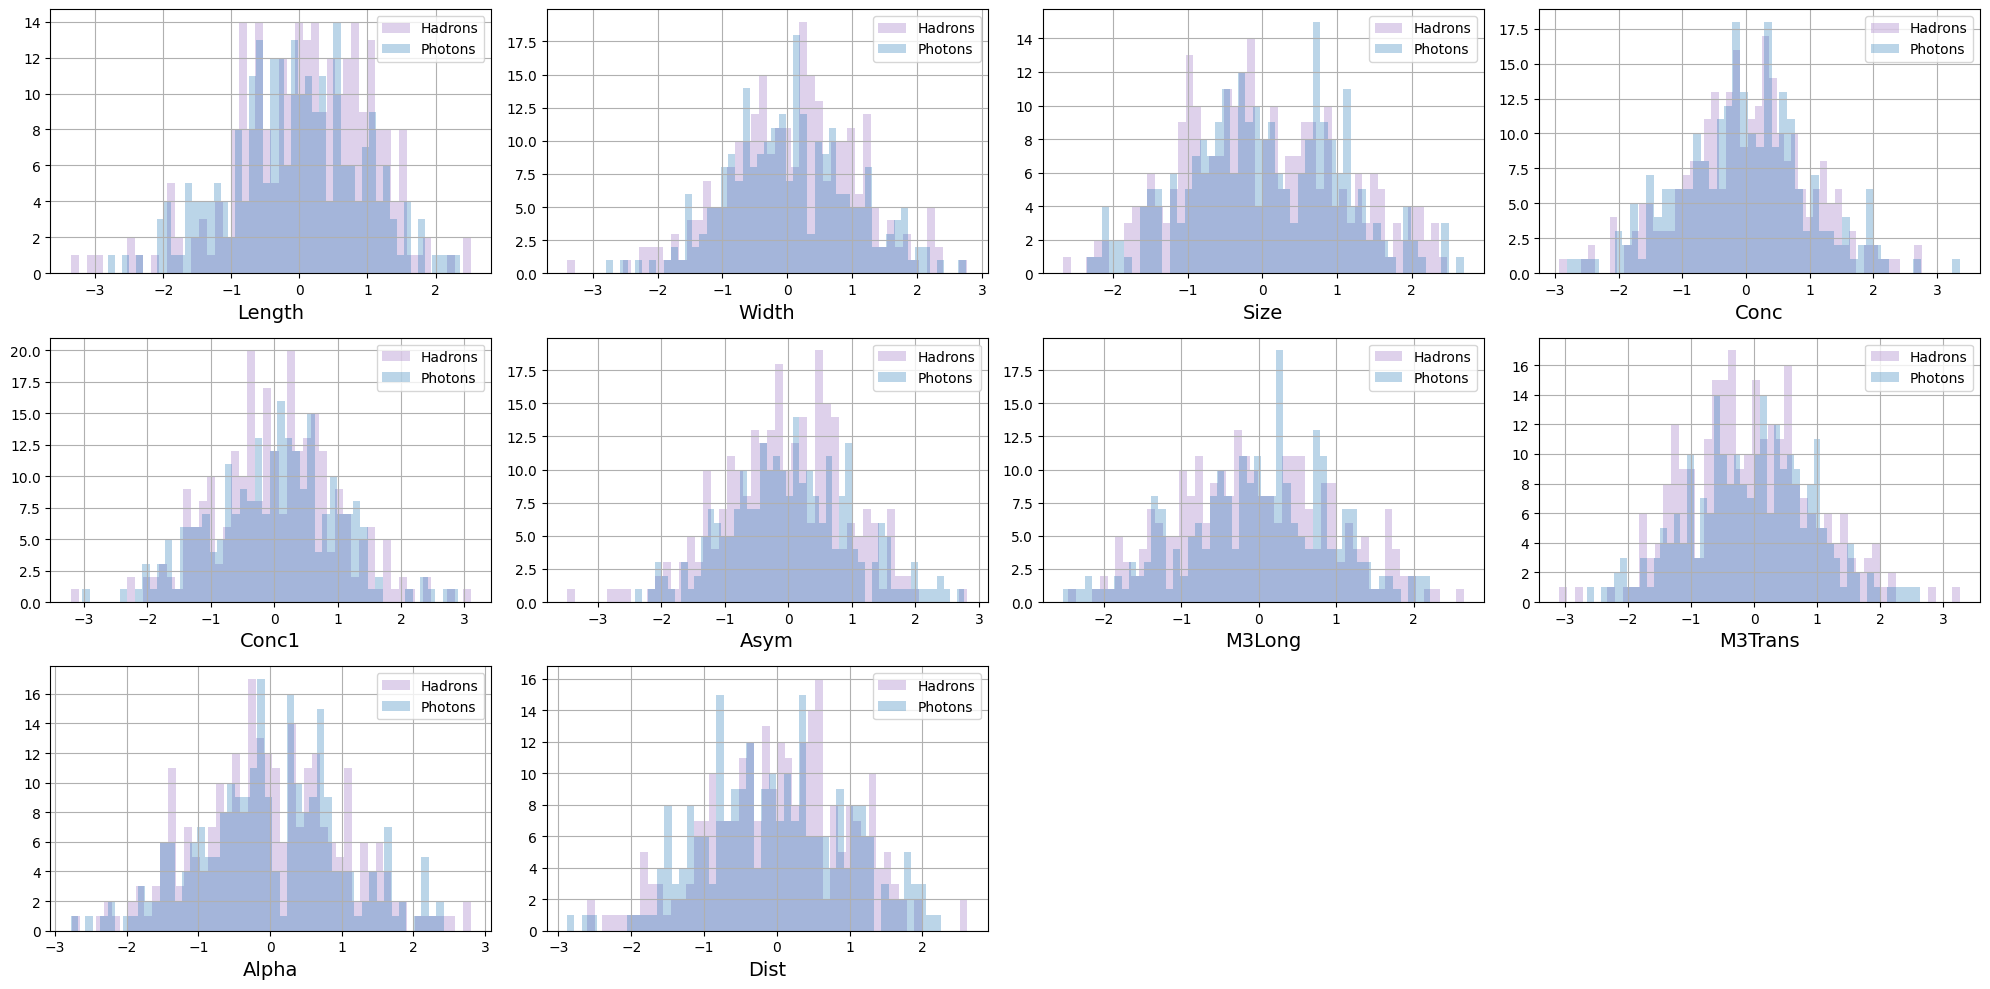

In [45]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

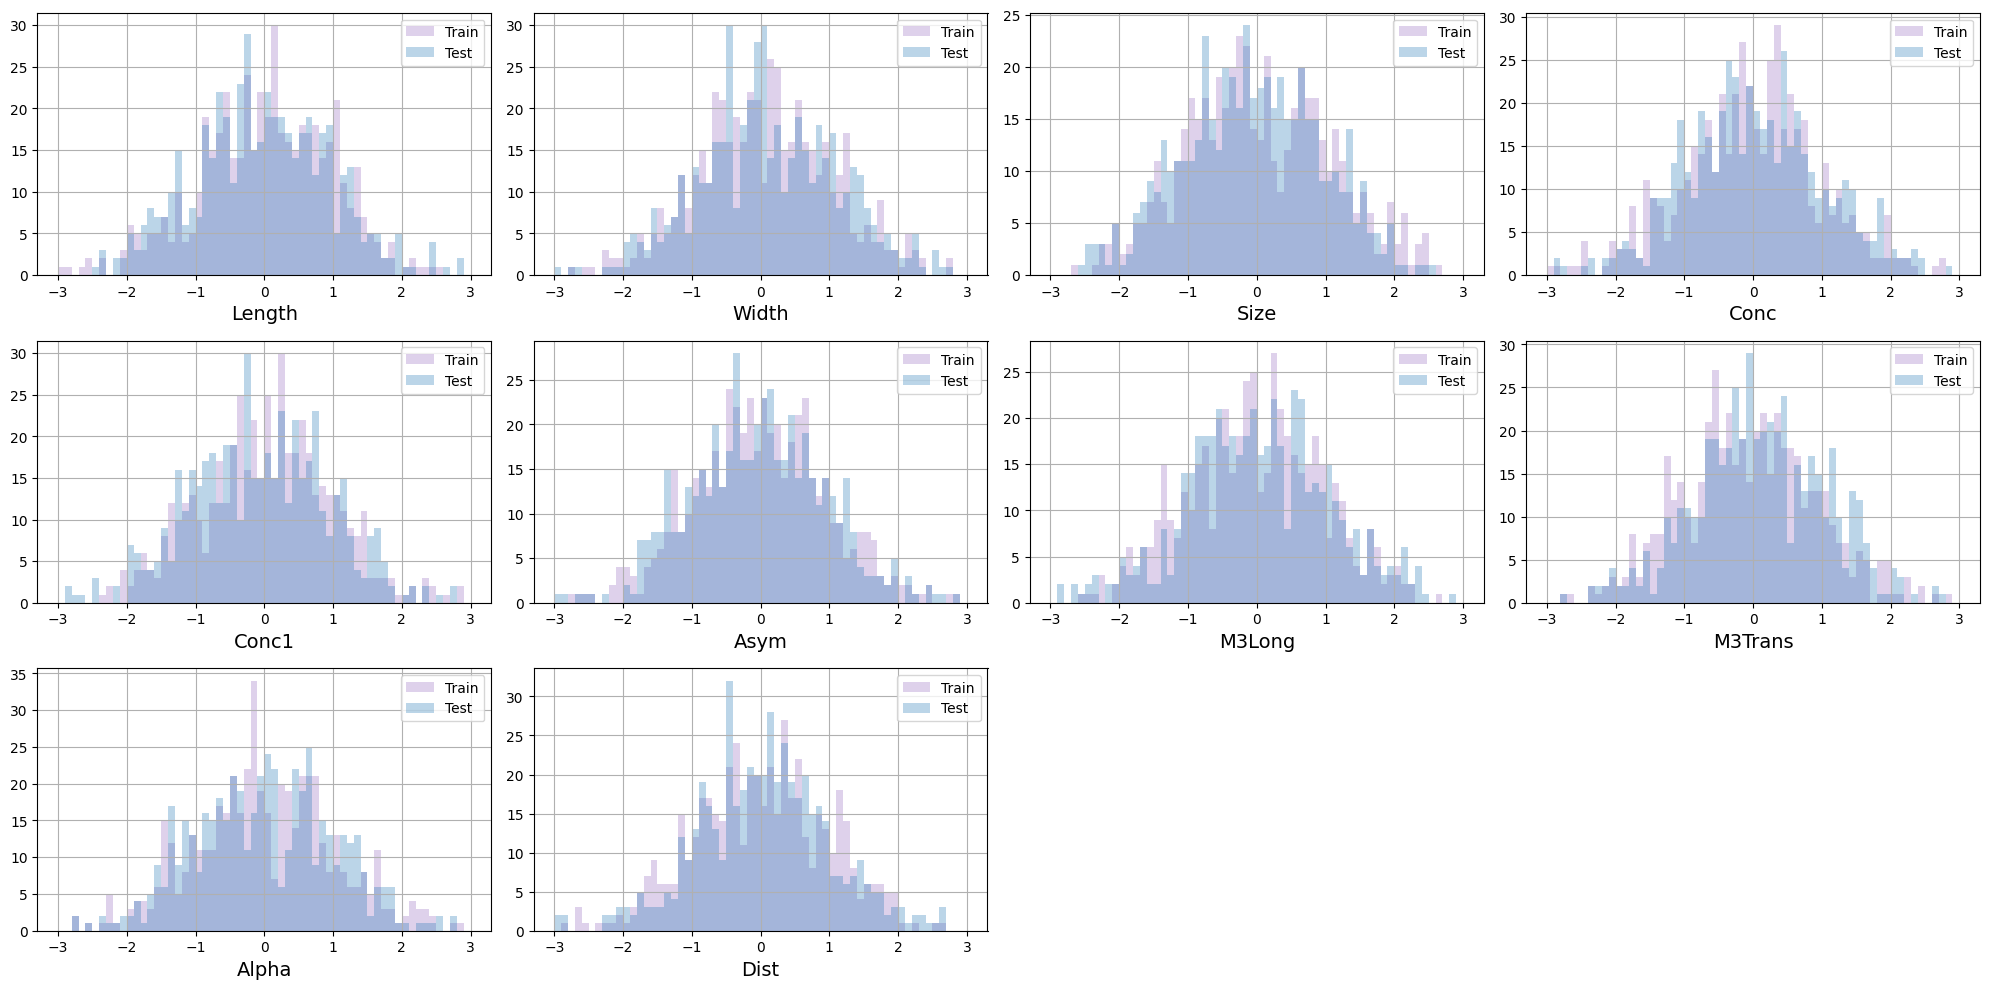

In [46]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения. 

<center><img src="img/cgan.png" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$. 

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
DEVICE

device(type='cpu')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [49]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
        )

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.model(zy)


## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [50]:
def generate(generator, y, latent_dim):
    z = torch.randn(y.size(0), latent_dim, device=DEVICE)  # Генерируем шумовой вектор z
    y = y.to(DEVICE)
    generator = generator.to(DEVICE)
    with torch.no_grad():
        generator.eval()  # Переводим модель в режим оценки
        X_fake = generator(z, y).cpu().detach().numpy()  # Генерация и перевод результата в numpy
    return X_fake


## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

In [51]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1)  # Без функции активации на выходе
        )

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.model(xy)


## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель логистической регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import numpy as np

def other_agent_score(X_real, y_real, X_fake, y_fake):
    # Объединение настоящих и фальшивых объектов
    X = np.concatenate([X_real, X_fake], axis=0)
    y = np.concatenate([y_real, y_fake], axis=0)
    
    # Разделение на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
    
    # Обучение модели логистической регрессии
    lin_reg = LogisticRegression(max_iter=1000, random_state=42)
    lin_reg.fit(X_train, y_train)
    lin_reg_score = accuracy_score(y_test, lin_reg.predict(X_test))
    
    # Обучение модели градиентного бустинга
    boosting = GradientBoostingClassifier(random_state=42)
    boosting.fit(X_train, y_train)
    boosting_score = accuracy_score(y_test, boosting.predict(X_test))
    
    print("Linear regression score: " + str(lin_reg_score))
    print("Boosting score: " + str(boosting_score))
    
    return lin_reg_score, boosting_score


## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Уточнение 1: Нужно ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора. Зачем это делать можно посмотреть в оригинальной статье <https://arxiv.org/pdf/1701.07875.pdf>.
- Подсказка 1: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 2: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [53]:
class Fitter(object):
    def __init__(self, generator, discriminator, batch_size=32, n_epochs=10, latent_dim=100, lr=0.0001, n_critic=5):
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

        self.loss_history = []  # Инициализируем список для хранения истории потерь

    def fit(self, X, y):
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        dataset_real = TensorDataset(X_real, y_cond)

        self.generator.train()
        self.discriminator.train()

        for epoch in range(self.n_epochs):
            disc_loss_epoch = []
            gen_loss_epoch = []
            for _ in range(self.n_critic):
                for real_batch, cond_batch in DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True):
                    self.opt_disc.zero_grad()

                    real_batch = real_batch.to(DEVICE)
                    cond_batch = cond_batch.to(DEVICE)

                    # Работа с реальными данными
                    output_real = self.discriminator(real_batch, cond_batch)
                    loss_real = -torch.mean(output_real)

                    # Генерация и работа с фейковыми данными
                    z = torch.randn(real_batch.size(0), self.latent_dim, device=DEVICE)
                    fake_batch = self.generator(z, cond_batch)
                    output_fake = self.discriminator(fake_batch, cond_batch)
                    loss_fake = torch.mean(output_fake)

                    # Обновление дискриминатора
                    loss_disc = loss_real + loss_fake
                    loss_disc.backward()
                    self.opt_disc.step()

                    # Ограничение весов дискриминатора
                    for p in self.discriminator.parameters():
                        p.data.clamp_(-0.01, 0.01)

                    disc_loss_epoch.append(loss_disc.item())

            # Обновление генератора
            self.opt_gen.zero_grad()
            z = torch.randn(self.batch_size, self.latent_dim, device=DEVICE)
            fake_batch = self.generator(z, cond_batch)
            output = self.discriminator(fake_batch, cond_batch)
            loss_gen = -torch.mean(output)
            loss_gen.backward()
            self.opt_gen.step()
            gen_loss_epoch.append(loss_gen.item())

            # Среднее значение потерь за эпоху
            avg_disc_loss = sum(disc_loss_epoch) / len(disc_loss_epoch)
            avg_gen_loss = sum(gen_loss_epoch) / len(gen_loss_epoch)
            self.loss_history.append((avg_disc_loss, avg_gen_loss))

            print(f"Epoch: {epoch}, Loss D: {avg_disc_loss}, Loss G: {avg_gen_loss}")

        self.generator.eval()
        self.discriminator.eval()


## Обучение
Обучим модель на данных.

In [54]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

Epoch: 0, Loss D: -0.000978920329362154, Loss G: -0.01102142408490181
Epoch: 1, Loss D: -0.00094833604991436, Loss G: -0.011208628304302692
Epoch: 2, Loss D: -0.0016199789382517337, Loss G: -0.011355963535606861
Epoch: 3, Loss D: -0.0021853602677583696, Loss G: -0.011469955556094646
Epoch: 4, Loss D: -0.0025782476179301737, Loss G: -0.011506285518407822
Epoch: 5, Loss D: -0.0028638915531337262, Loss G: -0.011574518866837025
Epoch: 6, Loss D: -0.0030388277769088745, Loss G: -0.011650902219116688
Epoch: 7, Loss D: -0.003162475638091564, Loss G: -0.01161928754299879
Epoch: 8, Loss D: -0.003188655748963356, Loss G: -0.011542138643562794
Epoch: 9, Loss D: -0.0032410548813641073, Loss G: -0.011560252867639065
Epoch: 10, Loss D: -0.003219102993607521, Loss G: -0.011631433852016926
Epoch: 11, Loss D: -0.0032176388427615165, Loss G: -0.011535552330315113
Epoch: 12, Loss D: -0.0031983532756567003, Loss G: -0.011677746661007404
Epoch: 13, Loss D: -0.0031756511516869068, Loss G: -0.011601660400629

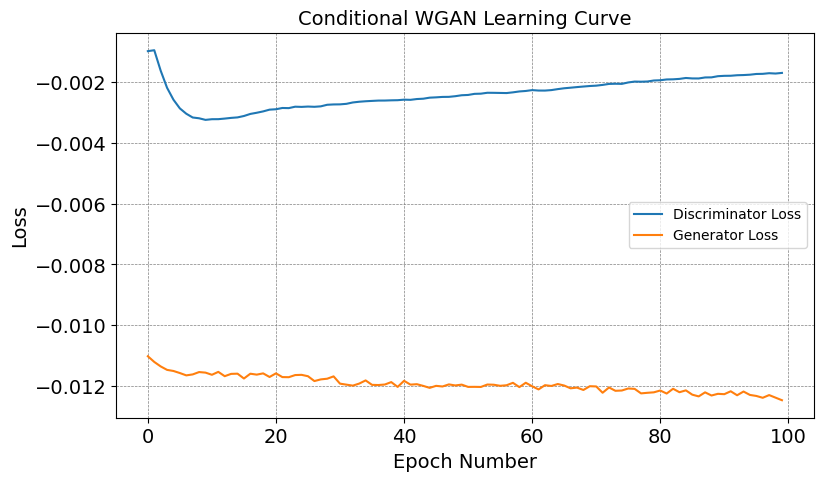

In [55]:
plt.figure(figsize=(9, 5))
disc_losses, gen_losses = zip(*fitter.loss_history)  # Разделение потерь дискриминатора и генератора
plt.plot(disc_losses, label='Discriminator Loss')  # Потери дискриминатора
plt.plot(gen_losses, label='Generator Loss')  # Потери генератора
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, color="0.5")  # Корректное включение и настройка сетки
plt.show()


## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [56]:
### YOUR CODE IS HERE ######

### THE END OF YOUR CODE ###

In [64]:
# Генерация фейковых данных
X_fake_train = generate(fitter.generator, torch.tensor(y_train, dtype=torch.float), latent_dim)
X_fake_test = generate(fitter.generator, torch.tensor(y_test, dtype=torch.float), latent_dim)

# Применение обратного квантильного преобразования к сгенерированным данным
X_fake_train_inverse = qt.inverse_transform(X_fake_train)
X_fake_test_inverse = qt.inverse_transform(X_fake_test)

# Применение обратного квантильного преобразования к реальным данным (если они уже трансформированы и нужно получить исходный масштаб)
# Это шаг нужен только если вы хотите визуализировать исходные данные в их первоначальном масштабе для сравнения
X_train_original_scale = qt.inverse_transform(X_train)
X_test_original_scale = qt.inverse_transform(X_test)


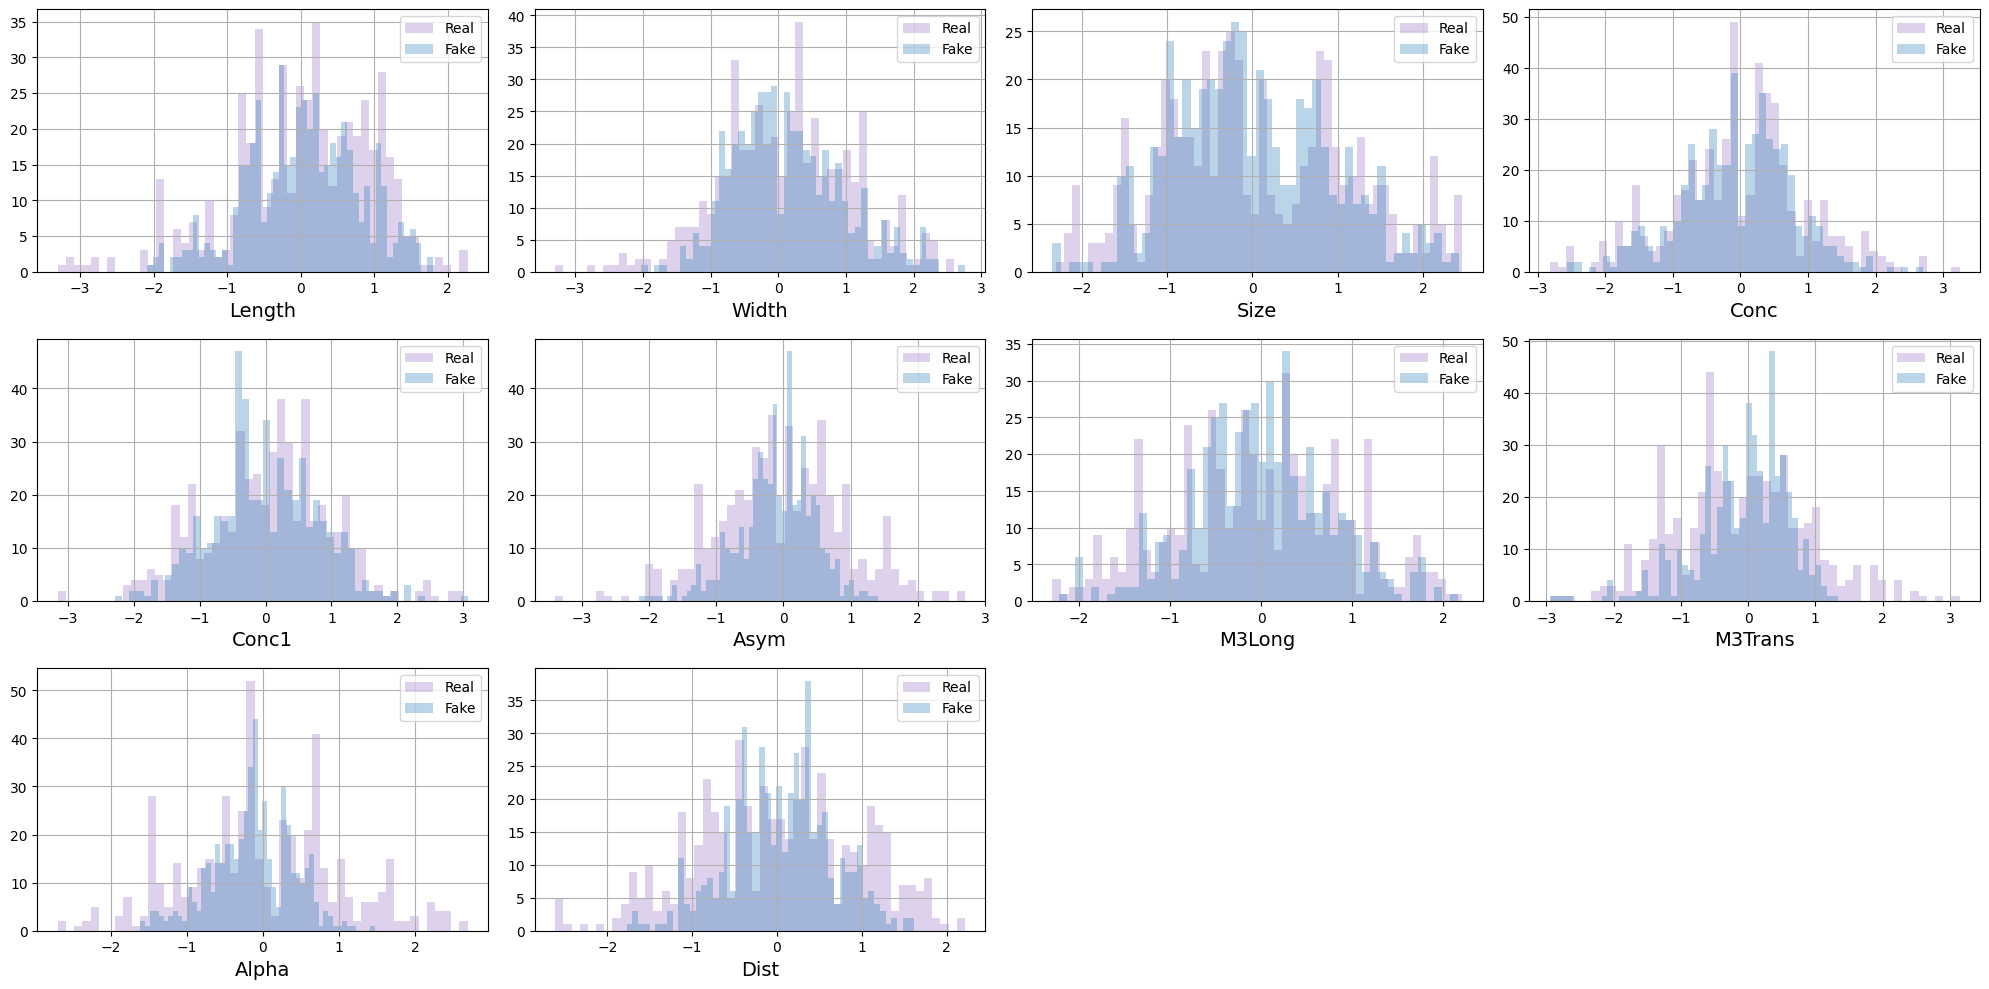

In [65]:
plot_hists(X_train_original_scale, X_fake_train_inverse, names[:-1], label1="Real", label2="Fake", bins=50)

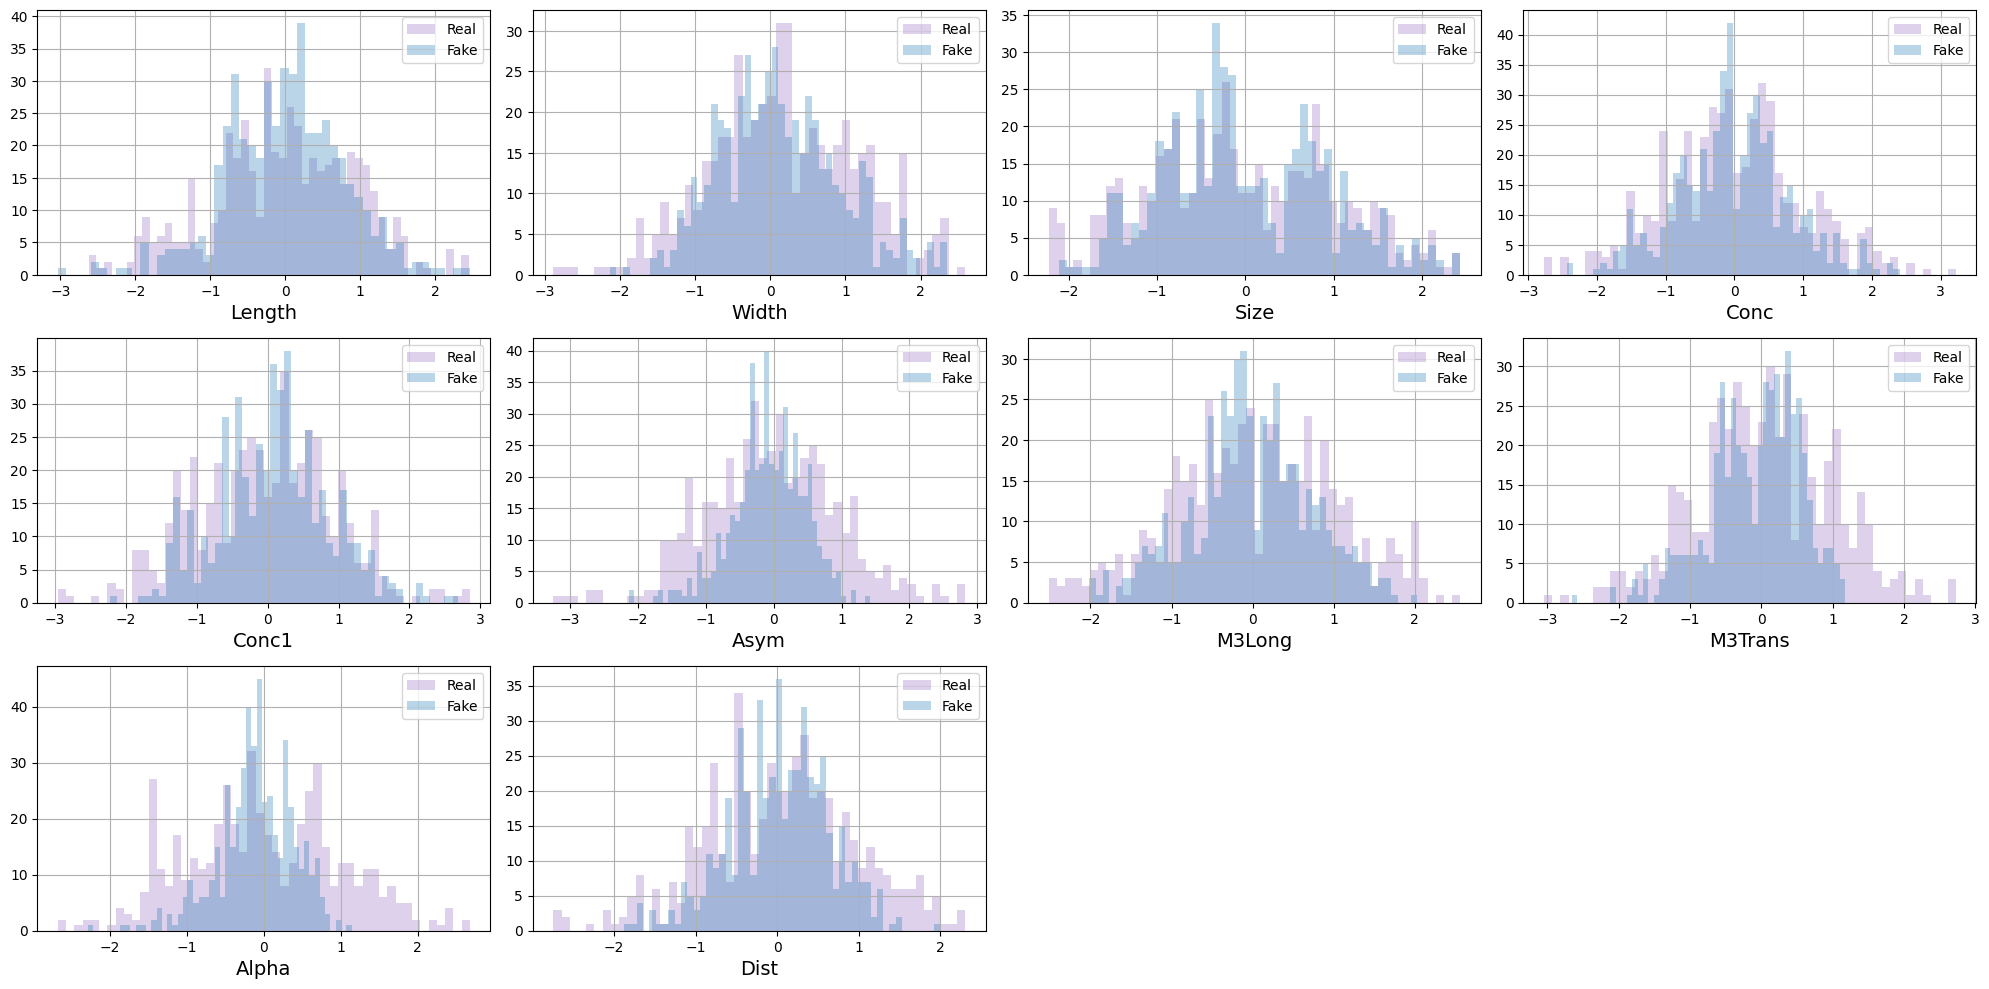

In [66]:
plot_hists(X_test_original_scale, X_fake_test_inverse, names[:-1], label1="Real", label2="Fake", bins=50)

## Вывод: 
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

<center><img src="img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

In [67]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [68]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [69]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.879892


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


Ваш эксперимент направлен на оценку качества сгенерированных данных по сравнению с реальными данными с использованием классификатора. Используя генеративно-состязательную сеть (GAN), вы сгенерировали наборы фейковых данных, которые затем объединили с реальными данными для обучения и тестирования классификатора на основе градиентного бустинга. Целью классификатора было различить реальные данные от сгенерированных. Качество различения оценивалось с помощью метрики ROC AUC.

**ROC AUC = 0.879892** говорит о том, что классификатор достаточно хорошо, но не идеально, различает реальные данные от сгенерированных. ROC AUC (площадь под кривой ошибок) является мерой способности классификатора различать два класса: чем ближе значение к 1, тем лучше классификатор различает классы. В идеале, для совершенно неотличимых распределений реальных и сгенерированных данных ROC AUC должен стремиться к 0.5, что означало бы, что классификатор работает на уровне случайного угадывания.

### Оценка результатов

Полученное значение ROC AUC в 0.879892 указывает на то, что сгенерированные данные имеют различия по сравнению с реальными данными, которые классификатор смог выявить. Это может говорить о том, что, несмотря на высокое качество генерации, существуют определенные характеристики или паттерны в реальных данных, которые генеративная модель не смогла полностью воспроизвести.

### Какое значение ROC AUC нас удовлетворяет больше всего?

В контексте оценки качества сгенерированных данных, нас больше всего удовлетворяло бы значение ROC AUC, близкое к 0.5. Это означало бы, что классификатор не может эффективно различать между реальными и сгенерированными данными, что в свою очередь указывало бы на высокое качество генерации данных генеративной моделью. Такой результат свидетельствовал бы о том, что сгенерированные данные хорошо имитируют распределение реальных данных и могут быть использованы в приложениях, где требуется высокая степень сходства с реальными данными.

Таким образом, хотя достигнутое значение ROC AUC свидетельствует о неплохом качестве различения, для целей генерации данных, которые должны быть неотличимы от реальных, идеальным результатом было бы значение, ближе к 0.5.

## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [70]:
def corrupt(x, amount):
    noise = torch.randn_like(x) * amount  # Генерация шума с заданной амплитудой
    x_noised = x + noise  # Добавление шума к данным
    return x_noised


## Добавим sсheduler, он пригодится вам при обучении модели

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
)
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?). 

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [71]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
        )

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        output = self.model(zy)
        return output

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [72]:
def generate_with_diffusion(model, y, latent_dim, scheduler):
    # Инициализация начального шумового вектора
    z = torch.randn(len(y), latent_dim, device=DEVICE)
    y = torch.tensor(y, dtype=torch.float, device=DEVICE)
    
    # Процесс диффузии
    for i in range(scheduler.num_train_timesteps):
        # Вычисление уровня шума на текущем шаге
        noise_level = scheduler.get_noise_level(i).to(DEVICE)
        z = corrupt(z, noise_level)
        # Можно добавить шаги с использованием модели, если это часть вашего процесса генерации
    
    # Предполагается, что модель принимает зашумленные данные и вектор условий и генерирует данные
    X_fake = model(z, y).cpu().detach().numpy()
    return X_fake


## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [80]:
class DiffusionFitter(object):
    def __init__(self, model, batch_size=32, n_epochs=10, latent_dim=10, lr=0.0001, n_critic=5):
        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic
        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)
        self.model.to(DEVICE)
        self.loss_history = []  

    def fit(self, X, y):
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)
        
        dataset_real = TensorDataset(X_real, y_cond)
        
        self.model.train(True)
        
        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for real_batch, cond_batch in DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True):
                self.opt_gen.zero_grad()
                
                z = torch.randn(real_batch.size(0), self.latent_dim, device=DEVICE)
                # Убедитесь, что cond_batch также передается в модель, если это необходимо
                generated_data = self.model(z, cond_batch)

                # Вычисление функции потерь, используя выход модели и реальные данные
                loss = torch.nn.functional.mse_loss(generated_data, real_batch)
                
                loss.backward()
                self.opt_gen.step()
                
                loss_epoch += loss.item()
        
            self.loss_history.append(loss_epoch / len(DataLoader(dataset_real, batch_size=self.batch_size)))
        
        self.model.train(False)


In [81]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

CPU times: user 2.01 s, sys: 8.84 s, total: 10.9 s
Wall time: 1.09 s


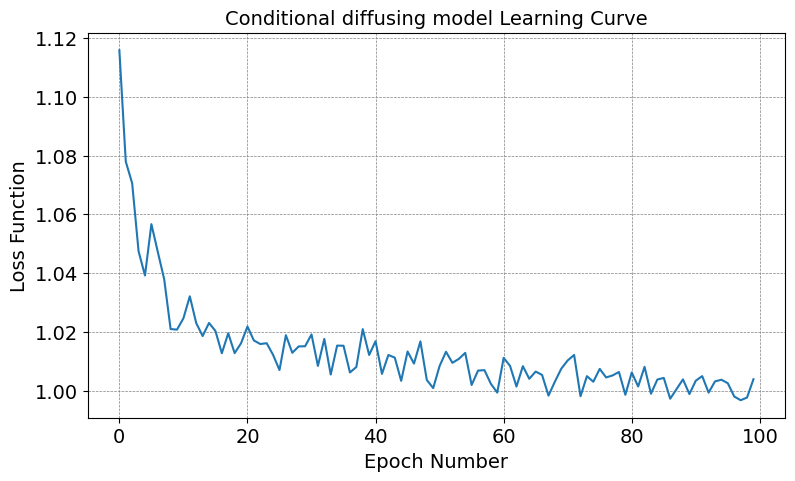

In [83]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(True, linestyle="--", linewidth=0.5, color="0.5")  # Исправленный вызов
plt.show()


## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

In [88]:
class SimpleNoiseScheduler:
    def __init__(self, num_steps=1000, start=0.01, end=0.1):
        self.num_train_timesteps = num_steps  # Исправлено: добавлен атрибут
        self.start = start
        self.end = end
        self.noise_levels = torch.linspace(start, end, num_steps)

    def get_noise_level(self, step):
        # Проверяем, что запрашиваемый шаг не превышает общее число шагов
        if step >= self.num_train_timesteps:
            raise ValueError("Step exceeds total number of timesteps")
        return self.noise_levels[step]


In [89]:
noise_scheduler = SimpleNoiseScheduler(num_steps=1000, start=0.01, end=0.1)

In [90]:
# Сгенерируем фейковые данные для тестовой выборки
X_fake_test_2 = generate_with_diffusion(diffusionFitter.model, y_test, latent_dim, noise_scheduler)

# Объединим реальные и сгенерированные данные в один датасет
XX_test = np.concatenate((X_test, X_fake_test_2), axis=0)
yy_test = np.array([1] * len(X_test) + [0] * len(X_fake_test_2))  # 1 - реальные, 0 - фейковые

XX_train, XX_val, yy_train, yy_val = train_test_split(XX_test, yy_test, test_size=0.5, random_state=42)

clf.fit(XX_train, yy_train)

# Получаем прогнозы для валидационной выборки
yy_val_pred = clf.predict_proba(XX_val)[:, 1]
yy_val_pred_binary = clf.predict(XX_val)

# Рассчитаем метрики
roc_auc = roc_auc_score(yy_val, yy_val_pred)
accuracy = accuracy_score(yy_val, yy_val_pred_binary)
print(f"ROC AUC: {roc_auc:.4f}, Accuracy: {accuracy:.4f}")

ROC AUC: 0.9954, Accuracy: 0.9700


## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!